# Machine learning needs data

Without data, machine learning is nothing. After all what will it learn if it has nothing to learn from. Think about everything you've learned throughout your life. All the books you've read, the movies you've watched, the experiences you've lived. Everything you've touched, tasted, heard, felt, smelled. It all comes together to shape who you are and what you know. Our brains adapt and change to all of this input. Our brains _learn_. Take away all of the memories and experiences and what are we left with? Thoughts maybe, but of what? Without the context of our life there isn't much to think about. Machine learning models work kind of like our brain, but much simpler. They take data and try to make sense of it, or _learn_ from it. The more data, the easier it is to learn from, at least in theory.

## Quality vs. quantity

While we will dive into many algorithms over the course of this book, I want to drive home that machine learning models _need_ data to learn. We can have the fanciest neural network on the best GPU cluster in the world, but without data, it's all pointless. To drive this point home let's see some machine learning in action.

We'll start with a line. Nothing special, just the equation `y = x`.

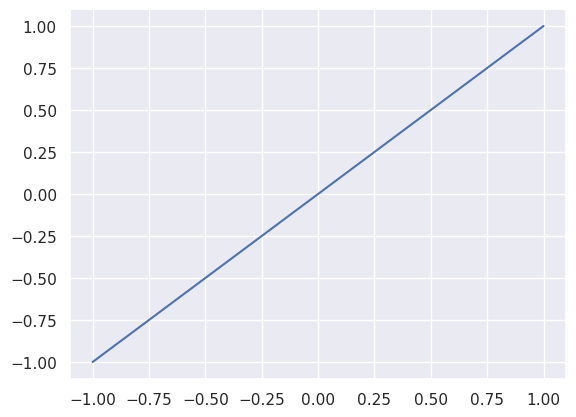

In [1]:
import seaborn as sns
sns.set_theme(style='darkgrid')

x = y = [-1, 1]
_ = sns.lineplot(x=x, y=y)

[I love [`seaborn`](https://seaborn.pydata.org/) for rapid data visualization. It can't do everything perfectly, but it does the common things beautifully.]{.aside}This line is the ground truth. It is real. But let's imagine we don't have the line. We just have a couple random points on the line.

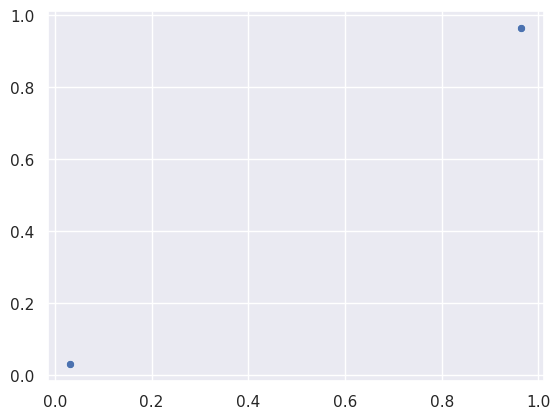

In [2]:
import random
import pandas as pd

random.seed(100392)

def random_x(n):
    """Return `n` random values from -1 to 1."""
    return [random.uniform(-1, 1) for _ in range(n)]

xs = ys = random_x(2)
_ = sns.scatterplot(x=xs, y=ys)

Visually, we could draw a line from dot to dot and we'd get the same line in the previous plot. But we're not interested in figuring out the line ourselves. We're here to have machine learning do it for us. This is already integrated into `seaborn` so there's not much code for us to write. The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function will plot our data points and use machine learning to fit a line to those data points.

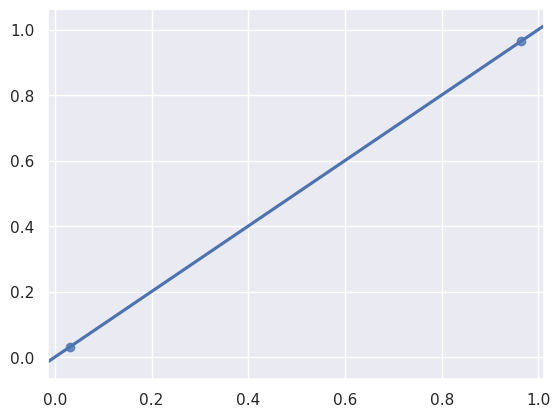

In [3]:
_ = sns.regplot(x=xs, y=ys, truncate=False, ci=False)

Will you look at that! The line was perfectly predicted based on the data points.

But real world data isn't this simple or this _clean_. There's usually some amount of noise[Noise is randomness introduced to the data. It can come from many places like imprecise measurements, mislabelling, or unaccounted variables to name a few.]{.aside} in the data that can affect the quality of predictions.

Now let's imagine we don't have points on the line, but points close to the line. How will this change the predicted line?

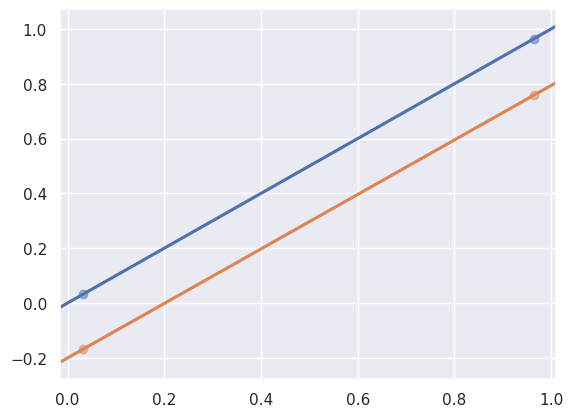

In [4]:
# Add noise to the data points to simulate noisy data.
def noisy_process(xs, noise):
    """Return noisy values of `xs`."""
    return [x + random.uniform(-noise, noise) for x in xs]

ys_noisy = noisy_process(xs, .25)

ax = sns.regplot(x=xs, y=ys, truncate=False, ci=False, scatter_kws={'alpha': 0.5})
_ = sns.regplot(x=xs, y=ys_noisy, truncate=False, ci=False, ax=ax, scatter_kws={'alpha': 0.5})

Hmm, that doesn't look so bad. The predicted line in orange is pretty close to the real line in blue and has the same slope. But what if we just got lucky and the random noise happened to be low? Maybe we should run it a few more times to be sure.[`pandas` is another great library we'll use over and over again. We'll get to more on that later.]{.aside}

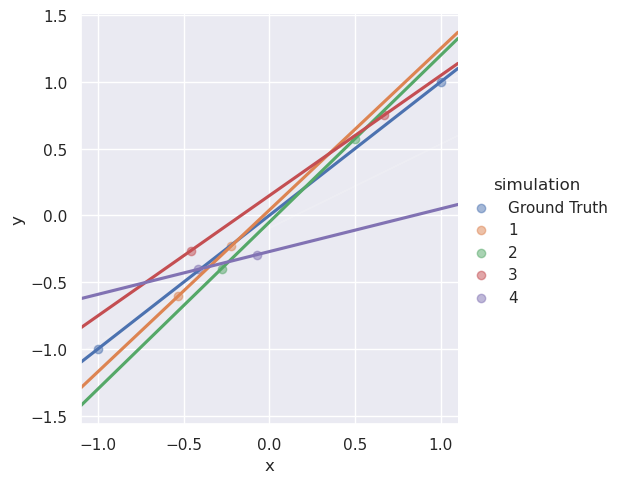

In [5]:
import pandas as pd

def simulate_n(n, n_points, noise):
    """Return a `pd.DataFrame` with `n` separate simulations of `n_points`."""
    data = []
    for x in [-1, 1]:
        data.append({'x': x, 'y': x, 'simulation': 'Ground Truth', 'noise': noise})
    for i in range(n):
        xs = random_x(n_points)
        ys = noisy_process(xs, noise)
        for x, y in zip(xs, ys):
            data.append(
                {'x': x, 'y':y, 'simulation': i+1, 'noise':noise}
            )
    return pd.DataFrame(data)

df = simulate_n(4, 2, 0.25)
# `lmplot` is a fancier version of `regplot` that can handle multiple
# lines.
_ = sns.lmplot(df, x="x", y='y', ci=False, hue='simulation', truncate=False, scatter_kws={'alpha': 0.5})

Most of these look pretty close to the blue line, the ground truth, but what's going on with simulation 4? The noise confused the machine learning model. It only has two points to work with and given two points it can figure out a line that perfectly lies on those two points. These two points imperfectly represent the real line and so the machine learned the line of this imperfect representation. And it gets worse with more noise.

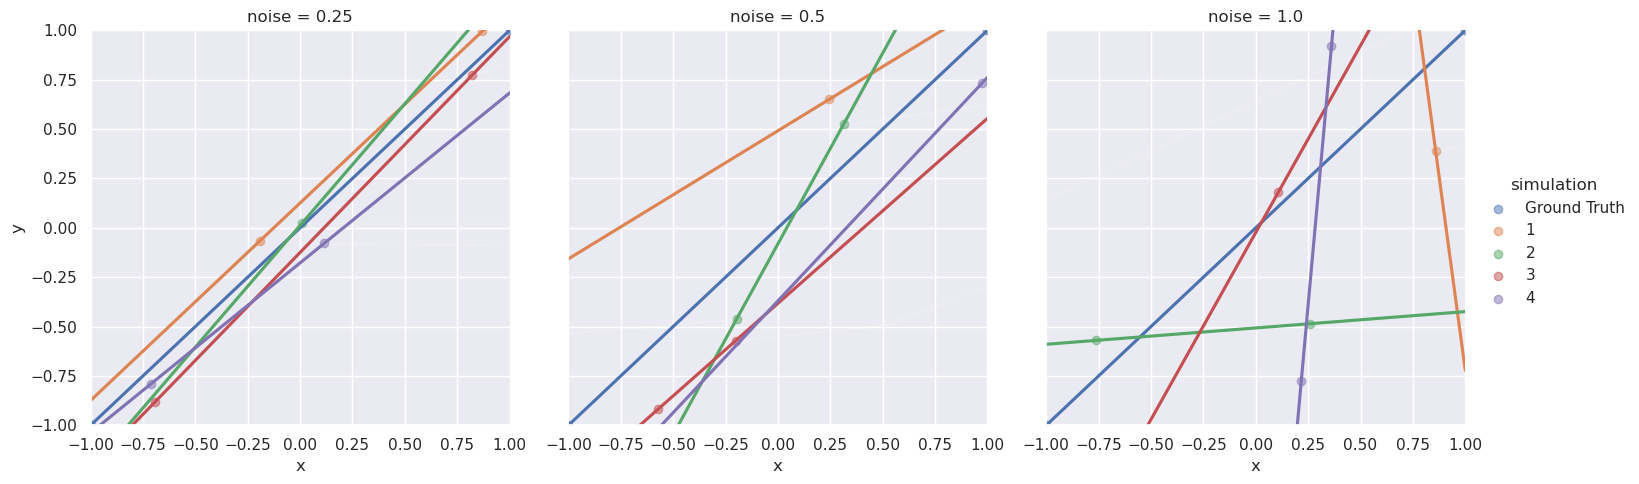

In [6]:
df = pd.concat([simulate_n(4, 2, noise) for noise in [0.25, 0.5, 1]])
_ = sns.lmplot(df, x='x',y='y', ci=False, hue='simulation', truncate=False, col='noise', scatter_kws={'alpha': 0.5},facet_kws={'xlim':(-1, 1), 'ylim':(-1, 1)})

Yup, that's a mess. But there is a way to learn from noisy data, you just need more of it. Let's try a hundred points per simulation.

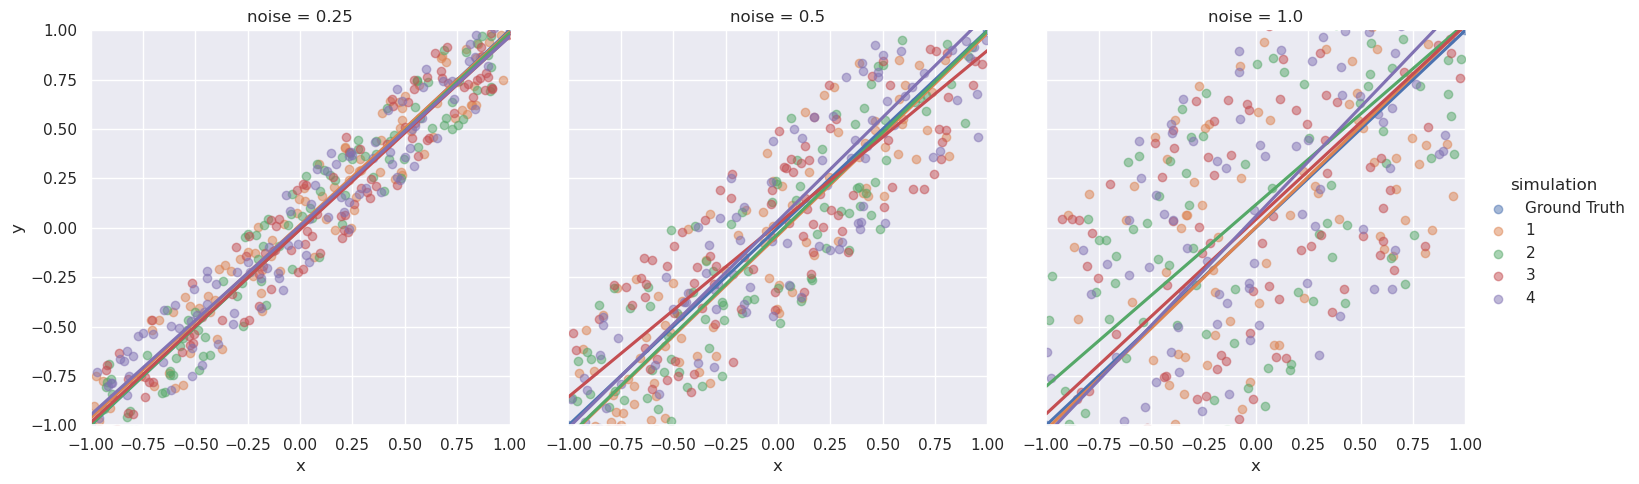

In [7]:
df = pd.concat([simulate_n(4, 100, noise) for noise in [0.25, 0.5, 1]])
_ = sns.lmplot(df, x='x',y='y', ci=False, hue='simulation', truncate=False, col='noise', scatter_kws={'alpha': 0.5},facet_kws={'xlim':(-1, 1), 'ylim':(-1, 1)})

That's night and day compared to two data points. Even when `noise = 1.0` the machine learning model does a good job of finding the line. This is because there's more information to learn from and the machine learning model can separate the noise and zero in on the truth.

The lesson here is data quality is important, but so is data _quantity_. Sometimes the answer is a better machine learning model, but that's not always true, you might just need more data.

## Getting the data

Our models will be using a dataset of movie reviews from IMDB [@maas-EtAl:2011:ACL-HLT2011]. There are several ways to get your hands on a dataset, you can curate them yourself or rely on the work of others. This dataset can be found at [https://ai.stanford.edu/~amaas/data/sentiment](https://ai.stanford.edu/~amaas/data/sentiment), but for simplicities sake it's downloadable from this github repo.

Let's grab the data!

In [8]:
import tarfile
from pathlib import Path

import requests

tar_path = Path('aclImdb_v1.tar.gz')
if not tar_path.exists():
    r = requests.get('https://github.com/spenceforce/NLP-Simple-to-Spectacular/releases/download/aclImdb_dataset/aclImdb_v1.tar.gz', stream=True)
    with tar_path.open('wb') as f:
        for chunk in r.iter_content(chunk_size=128):
            f.write(chunk)

with tarfile.open(tar_path) as tar:
    tar.extractall(filter='data')
    data_path = Path('aclImdb')
    # The untarred directory is `aclImdb` instead of `aclImdb_v1`.

This extracts the data from the tarball then assigns the output directory as a `pathlib.Path` object to `data_path`.[I highly recommend checking out the [pathlib](https://docs.python.org/3/library/pathlib.html) library if you don't already use it. It provides a nice object oriented API for handling file paths.]{.aside}

There are a lot of datasets out there. Some better than others. Before trying to predict anything, it's a good idea to get a sense of what the dataset actually contains. Hopefully the datasets you're using are well documented. The dataset we're working with comes with a README which we can see in the directory contents.[Don't worry if the paths shown in this notebook are different from the ones you see on your compute resource. The structure of the data directory should be the same, and by leveraging relative paths with `Path` objects, everything should just work.]{.aside}

In [9]:
list(data_path.iterdir())

[PosixPath('aclImdb/imdbEr.txt'),
 PosixPath('aclImdb/README'),
 PosixPath('aclImdb/train'),
 PosixPath('aclImdb/imdb.vocab'),
 PosixPath('aclImdb/test')]

If you're working through this notebook in jupyter, I recommend taking a pause and reading the README yourself.

I'll summarize the main takeaways here for those of you reading this online.

### Overview

This dataset contains movie reviews and labels indicating if the review is positive (label 1) or negative (label 0). It is intended for benchmarking sentiment classification tasks. Sentiment classification is about predicting the feeling a text conveys. Like emotions such as happy, sad, or angry. In this case it's predicting whether a review says if a movie is good or bad.

### Dataset specifics

There are 50k reviews, split into two groups of 25k. One group is for training machine learning models and the other is for testing them. Within each group of 25k, the reviews are split into half positive and half negative.

There's at most 30 reviews for a given movie. The train and test sets have reviews for different movies, so none of the movies reviewed in the train set show up in the test set. Negative reviews have a score of 4 or less and positive reviews have a score of 7 or more.

There are an additional 50k reviews without any labels. These reviews are intended for unsupervised learning purposes (we'll learn about unsupervised learning in the future). There is an equal number of reviews with a score of 4 or less and 5 or more.

### Directory structure

The classification dataset file naming convention is `[DATASET]/[LABEL]/[ID]_[RATING].txt` where `DATASET` is one of `train` or `test`, `LABEL` is one of `pos` or `neg` (for positive and negative respectively), `ID` is a numeric identifier for a review, and `RATING` is the score the reviewer gave the movie.[A word of warning for jupyter lab users. Jupyter crashed when I tried to open the directories containing the reviews (like `train/pos`). My guess is there's too many files for jupyter to display and it becomes unresponsive. Your mileage may vary.]{.aside}

The unsupervised dataset file naming convention is `train/unsup/[ID]_0.txt` where `ID` is a numeric identifier for a review.

URLs to the reviews section are also provided in `[DATASET]/urls_[LABEL].txt`. The line `N` refers to `ID` `N` in the associated dataset/label combination. For example line 200 in `train/urls_pos.txt` refers to the reviews webpage for the movie of `train/pos/200_10.txt`. Here's an example URL from one of these files: http://www.imdb.com/title/tt0064354/usercomments. It turns out IMDB has changed their URL format so this link is broken. They now use "reviews" in place of "usercomments" like http://www.imdb.com/title/tt0064354/reviews. It is possible to mine additional information about these movies using these URLs, but APIs change and trying to gather that information programmatically over the web could break in the future so this book will focus on just the reviews.

## Question the dataset

An integral part of building a machine learning model is understanding where the data comes from and how it was acquired. There may be assumptions made during the data curation process that you don't agree with. An artefact in the data may have unintended side effects downstream, such as training a model that works very well on data it's seen but performs poorly on data it hasn't.

As you read about the dataset and it's curation process, I recommend you keep asking "why?" to better understand the choices made during the curation process. Why did they use those specific thresholds for choosing positive vs negative labels? Why that ratio of positive/negative labels? Why that many reviews per movie? Why set up the train/test sets that way?

In parallel, also think about _how_ you are going to leverage this data. Your end goal may be different from the curators of the dataset and that should be taken into account as you prepare the data for training machine learning models.

Here's a couple questions that come to my mind.

- Why isn't there a dataset for multi-label classification?
- Why a maximum of 30 reviews per movie? Why not 10 or 50?
- What was the rationale for picking the movies? Was it random or spread evenly by genre?
- Were the movies made during a certain time period?

Some of these questions we could answer ourselves if we want to and they can lead to a richer set of information. [IMDB provides an API](https://developer.imdb.com/) to programmatically gather movie data over the web.[[OMDb API](https://www.omdbapi.com/) is another API that provides IMDB metadata. I found their service to be much more transparent on pricing and easier to get access to.]{.aside} With that tool one can gather movie genres, release dates, associated actors, and more. If we never ask the questions we'll never think to look. Maybe we curate our own dataset because this one doesn't provide what we need or it leads to further analysis of the data and the dataset is tweaked based on that analysis.

### Cleaning the data

The data is spread out across multiple files, we just need to gather it together in a nice package. That nice package will be a [`pandas`](https://pandas.pydata.org/) dataframe. Dataframes are tables. `pandas` provides a ton of functionality to manipulate tables and learn about their content. You can think of them as the python version of an excel spreadsheet. The boundaries between cleaning data and analysing data can be fuzzy at times, but for sake of simplicity we will only analyze the data as needed to properly clean it.

The pieces of information provided in this dataset are:

- ID
- review
- rating
- label
- movie ID (from the reviews URL `http://www.imdb.com/title/[MOVIE_ID]/usercomments`)

Let's gather the training set which is under `train/pos` and `train/neg`.

In [10]:
def get_review_data(reviews_dir, urls_file):
    """Return a `pd.DataFrame` containing the review ID, title ID, rating, and review."""
    with urls_file.open() as f:
        title_ids = {i: url.split('/')[4] for i, url in enumerate(f.readlines())}

    data = []
    for p in (reviews_dir).iterdir():
        ID, rating = map(int, p.stem.split('_'))
        data.append(
            {
                "id": ID,
                "movie_id": title_ids[ID],
                "rating": rating,
                "review": p.open().read().strip()
            }
        )

    return pd.DataFrame(data)

def get_train_data():
    dfs = []
    for label, label_name in enumerate(['neg', 'pos']):
        df = get_review_data(data_path/'train'/label_name, data_path/f'train/urls_{label_name}.txt')
        df['label'] = label
        dfs.append(df)
    return pd.concat(dfs)

In [11]:
train_df = get_train_data()
train_df.head()

,id,movie_id,rating,review,label
0,7275,tt0082799,1,"""National Lampoon Goes to the Movies"" (1981) i...",0
1,1438,tt0397501,4,"Well! What can one say? Firstly, this adaptati...",0
2,9137,tt0364986,1,"What can I say, this is a piece of brilliant f...",0
3,173,tt0283974,3,"A decent sequel, but does not pack the punch o...",0
4,8290,tt0314630,2,"Alan Rudolph is a so-so director, without that...",0


Those look like reviews! Now that we have data in hand to play with, what questions can we answer about it? Maybe we should verify the information provided by the curators of this dataset.

- Are there 25k reviews in the train set?
- Are they evenly split between positive and negative?
- Is the max number of reviews per movie 30?

We can use `DataFrame.info()` to answer the first question. This method gives some general information about the dataframe, including the column names, number of non-null values in each column, column data types, and the number of rows.[Null values include `None` and NaNs. NaN, or Not a Number, representa a number that is undefined, such as the result of dividing by 0.]{.aside}

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        25000 non-null  int64 
 1   movie_id  25000 non-null  object
 2   rating    25000 non-null  int64 
 3   review    25000 non-null  object
 4   label     25000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


This dataframe contains 25k entries, and all of those entries have non-null reviews. So the train set does contain 25k reviews. But we know nothing about the quality of these reviews. Are there duplicates? Empty strings? Are some complete gibberish? It's impossible to qualitatively check every data point, but checking some basic properties of the data can go a long way. I like to call these sanity checks. Let's start with duplicates. There's many ways to check this. We'll use `DataFrame.describe`.

In [13]:
train_df.describe(include=[object])

,movie_id,review
count,25000,25000
unique,3456,24904
top,tt0374240,This show comes up with interesting locations ...
freq,30,3


The `include=[object]` argument tells `describe` to look at columns with the `object` data type instead of numeric data types. Strings fall under the `object` type in `pandas`.

The `movie_id` column shows the most frequent movie ID shows up 30 times. So we know there's at most 30 reviews for a given movie in this dataset.

The `review` column has a count of 25k, but 24,904 unique entries which means there's 96 duplicate reviews. From a training perspective, it doesn't make sense to have duplicate items in the train set, but before we drop the duplicate reviews, let's take a peek at them to see if they belong to the same movie and have the same ratings and labels.

In [14]:
is_duplicate = train_df['review'].duplicated(keep=False)
duplicate_reviews = train_df[is_duplicate]

If you're not familiar with `pandas`, then it may look like there's a lot going on in these statements. `train_df['review']` accesses the `review` column in the dataframe. So `train_df['review'].duplicated(keep=False)` returns a list of `True` and `False` values for each index in the column indicating if the review at that index is a duplicate. `keep=False` tells the `duplicated` method to mark every instance of a duplicate as `True`. Now there is a list of `True`/`False` values associated with each review. This is passed to the dataframe as `train_df[is_duplicate]` which returns a filtered version of the dataframe where each row has a corresponding `True` value in `is_duplicate`. This gives us a dataframe with just the duplicated reviews.

Now that we have the duplicated reviews, let's dig into them a bit. Are they for the same movie? Do they have the same rating or label?

In [15]:
duplicate_nunique = duplicate_reviews.groupby('review').agg('nunique').head()
duplicate_nunique.head(3)

,id,movie_id,rating,label
review,,,,
"'Dead Letter Office' is a low-budget film about a couple of employees of the Australian postal service, struggling to rebuild their damaged lives. Unfortunately, the acting is poor and the links between the characters' past misfortunes and present mindsets are clumsily and over-schematically represented. What's most disappointing of all, however, is the portrayal is life in the office of the film's title: there's no mechanisation whatsoever, and it's quite impossible to ascertain what any of the staff really do for a living. Granted, part of the plot is that the office is threatened with closure, but this sort of office surely closed in the 1930s, if it ever truly existed. It's a shame, as the film's overall tone is poignant and wry, and there's some promise in the scenario: but few of the details convince. Overall, it feels the work of someone who hasn't actually experienced much of real life; a student film, with a concept and an outline, but sadly little else.",2,2,1,1
".......Playing Kaddiddlehopper, Col San Fernando, etc. the man was pretty wide ranging and a scream. I love watching him interact w/ Amanda Blake, or Don Knotts or whomever--he clearly was having a ball and I think he made it easier on his guests as well--so long as they Knew ahead of time it wasn't a disciplined, 19 take kind of production. Relax and be loose was clearly the name of the game there.<br /><br />He reminds me of guys like Milton Berle, Benny Hill, maybe Jerry Lewis some too. Great timing, ancient gags that kept audiences in stitches for decades, sheer enjoyment about what he was doing. His sad little clown he played was good too--but in a touching manner.<br /><br />Personally I think he's great, having just bought a two DVD set of his shows from '61 or so, it brings his stuff back in a fond way for me. I can remember seeing him on TV at the end of his run when he was winding up the series in 1971 or so.<br /><br />Check this out if you are a fan or curious. He was a riot.",2,2,1,1
"<br /><br />Back in his youth, the old man had wanted to marry his first cousin, but his family forbid it. Many decades later, the old man has raised three children (two boys and one girl), and allows his son and daughter to marry and have children. Soon, the sister is bored with brother #1, and jumps in the bed of brother #2.<br /><br />One might think that the three siblings are stuck somewhere on a remote island. But no -- they are upper class Europeans going to college and busy in the social world.<br /><br />Never do we see a flirtatious moment between any non-related female and the two brothers. Never do we see any flirtatious moment between any non-related male and the one sister. All flirtatious moments are shared between only between the brothers and sister.<br /><br />The weakest part of GLADIATOR was the incest thing. The young emperor Commodus would have hundreds of slave girls and a city full of marriage-minded girls all over him, but no -- he only wanted his sister? If movie incest is your cup of tea, then SUNSHINE will (slowly) thrill you to no end.",2,1,1,1


`groupby` is grouping rows with the same `review` column together into their own dataframes. The return value of this operation is a `DataFrameGroupBy`. This special dataframe type performs operations on each group as if they were their own dataframe instead of all rows in the dataframe. `agg` performs an operation on the entire dataframe, but since this is a `DataFrameGroupBy` object, the `agg` method is applied to each group. In this case it counts the number of unique values in each column. 

It turns out there are duplicate reviews for different movie IDs. It's possible duplicate reviews with different ratings or labels but since we only looked at the first three rows we can't say if that's true or not. Let's inspect the two reviews above that have multiple movie IDs.

In [16]:
is_first2 = duplicate_reviews['review'].isin(duplicate_nunique.index[:2])
duplicate_reviews[is_first2]

,id,movie_id,rating,review,label
10893,985,tt0223119,4,'Dead Letter Office' is a low-budget film abou...,0
12445,4102,tt0118939,4,'Dead Letter Office' is a low-budget film abou...,0
101,6069,tt0163806,8,".......Playing Kaddiddlehopper, Col San Fernan...",1
5458,9319,tt0043224,8,".......Playing Kaddiddlehopper, Col San Fernan...",1


Remember we are provided a URL for the comments section of each review which is where we extract the movie ID from. This means we can go backwards from movie ID to movie URL. One review is for movies at the URLs [http://www.imdb.com/title/tt0223119/reviews](http://www.imdb.com/title/tt0223119/reviews) and [http://www.imdb.com/title/tt0118939/reviews](http://www.imdb.com/title/tt0118939/reviews) and the other at [http://www.imdb.com/title/tt0163806/reviews](http://www.imdb.com/title/tt0163806/review) and [http://www.imdb.com/title/tt0043224/reviews](http://www.imdb.com/title/tt0043224/reviews). When I click on each pair[I checked these links in August 2024. The URL endpoints may have changed in the future.]{.aside} one gets redirected to the other. Movie IDs tt0223119 and tt0118939 are for [_Dead Letter Office_](https://www.imdb.com/title/tt0118939/), and tt0163806 and tt0043224 are for [_The Red Skelton Hour_](https://www.imdb.com/title/tt0043224/). Although they have different movie IDs, they are reviews for the _same movie_ and therefore are truly duplicate reviews. This is a one-to-many relationship; one movie can have many IDs.

While it's not incredibly important, _The Red Skelton Hour_ is actually a TV show. It turns out this dataset contains reviews for movies _and tv shows_. See what a little digging can turn up?

We could check every single movie ID for duplicate reviews manually (or have an intern do it) because it's possible there are duplicate reviews for different movies, but our task is to predict a label (positive or negative) given a review. Our models don't need to see the same review over and over again in order to make predictions about them...unless duplicate reviews have different labels! Why would we want to train on both examples in this case? If the same review can be positive or negative, then training a machine learning model with both examples will teach the model to be uncertain about some reviews where the language is more ambiguous.

Let's see if there's any duplicate reviews with multiple labels or ratings.

In [17]:
different_labels = (duplicate_nunique['label'] > 1) | (duplicate_nunique['rating'] > 1)
duplicate_nunique[different_labels]

,id,movie_id,rating,label
review,,,,


There isn't, which means these reviews stem from duplicate movie IDs. Since the labels are the same for each duplicate, I feel confident in just removing the duplicate entries. I've taken the liberty of performing this analysis on the test set and found the same issue, so we'll remove duplicates from the test set as well.

In [18]:
def get_df(dataset):
    dfs = []
    for label, label_name in enumerate(['neg', 'pos']):
        df = get_review_data(data_path/dataset/label_name, data_path/dataset/f'urls_{label_name}.txt')
        df['label'] = label
        dfs.append(df)
    return pd.concat(dfs)

def get_train_data(dedup=True):
    rv = get_df("train")
    if dedup:
        return rv.drop_duplicates("review").copy()
    return rv

def get_test_data(dedup=True):
    rv = get_df("test")
    if dedup:
        return rv.drop_duplicates("review").copy()
    return rv

train_df = get_train_data()
train_df.groupby('label').describe(include='object')

movie_id                        review         \
         count unique        top freq  count unique   
label                                                 
0        12432   2950  tt0888019   30  12432  12432   
1        12472   1390  tt0086383   30  12472  12472   

                                                               
                                                     top freq  
label                                                          
0      Well, what can it be said about this disaster?...    1  
1      After the usual chase scene, Jerry accidentall...    1

In [19]:
train_df.shape

(24904, 5)

We don't quite have 25k reviews split evenly across labels, but it's close enough. I think this is in good shape and we can turn our attention to the test set.

In [20]:
test_df = get_test_data()
test_df.groupby('label').describe(include='object')

movie_id                        review         \
         count unique        top freq  count unique   
label                                                 
0        12361   3005  tt0093142   30  12361  12361   
1        12440   1351  tt0312004   30  12440  12440   

                                                               
                                                     top freq  
label                                                          
0      I'm glad that I did not expect too much when I...    1  
1      Once upon a time, Troma, the company that brou...    1

In [21]:
test_df.shape

(24801, 5)

We've removed about 200 reviews from the test set and can start digging in to comparing the test set to the train set.

### Train-test contamination

Now let's talk a bit about what the test set is used for. It's a separate set of data used to evaluate a machine learning model after it's trained. It is data used to measure the performance of a model on data it's never seen before. This is important because when a model is used in production, it will be making predictions about all kinds of inputs it wasn't trained on and it needs to generalize well beyond the training data. __We do not want data leaking from the train set into the test set.__

Easy enough to check.

In [22]:
leak_df = test_df[test_df['review'].isin(train_df['review'])]
leak_df.shape

(123, 5)

There's 123 reviews from the train set in the test set.

Let's think about that for a second. The reviews in the test set should be for movies that aren't reviewed in the train set, but we have 123 reviews in the test set that are duplicates of those in the train set. How could this happen?

Remember that we saw duplicate reviews in the train set. This was a result of the same movie having multiple movie IDs. That could explain what's happening here. Maybe the reviews in both the train and test sets have different movie IDs. We can test that!

In [23]:
both_df = train_df.merge(test_df, on='review')
(both_df['movie_id_x'] == both_df['movie_id_y']).any()

np.False_

Bingo, by aligning the reviews with `merge()` we can directly compare movie IDs for duplicate reviews and none of them are the same. When this dataset was curated, this one-to-many relationship in the IMDB wasn't accounted for and resulted in not just duplicate reviews in the train and test sets independently, but also leakage of data from the train set into the test set. It gets worse though, we could remove the training reviews that leaked into the test set, but the test set _should only contain reviews for movies that aren't reviewed in the train set_. Because of the one-to-many relationship of movie title and movie IDs we have to further process the dataset to see if the movies reviewed in the test set are all different from those in the train set, even after removing duplicates.

Why is it important that there are no overlapping movies when the reviews are different? The curators of this dataset give a good explanation in the README they provide, 

> "In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels." [@maas-EtAl:2011:ACL-HLT2011]

Our goal is to train machine learning models that recognize general patterns of language to predict positive or negative sentiment for a given piece of text. If all the reviews in the train set for _Batman Begins_ are positive, the model may learn to associate words like "Batman", "Bruce Wayne", "Christian Bale", and "Christopher Nolan" with positive sentiment. This doesn't generalize to other movies. If reviews for _Batman Begins_ are in the test set, the model will likely correctly predict those reviews improving it's performance on the test set. The test set is supposed to be unbiased, but that goes out the window when data from the train set leaks into the test set.

::: {.callout-note}
There are a few forms of data leakage, but what I've described here is often called "train-test contamination". Basically when there's information specific to the train set that also shows up in the test set. In our case it's duplicate reviews and movie specific terms. It's a real problem in machine learning. It can make AI look better than it really is. Finding it in datasets can be tricky, especially as datasets get bigger and bigger. Thought needs to go into preventing sources of leakage and you may never catch every instance of leakage. For example, there's another instance of leakage that wasn't considered for this dataset. The train and test sets should contain reviews for a disjoint set of _reviewers_ because individual reviewers may use specific terms or have unique speech patterns that do not generalize to all reviewers and a machine learning model could learn that.
:::

First we'll remove the leakage of reviews from the train set into the test set.

In [24]:
def get_train_test_data():
    train_df = get_train_data()
    test_df = get_test_data()
    test_df = test_df[~test_df['review'].isin(train_df['review'])].copy()
    return train_df, test_df

Now, let's handle the leakage of movies from the train set into the test set. The way movie IDs work in IMDB is there's one main ID for a movie and other movie IDs for that movie point to the main ID. We saw this earlier when we looked at URLs for duplicate reviews. When you visit those URLs, the duplicate movie ID redirects to the main one. Try it with these URLS, [http://www.imdb.com/title/tt0223119/reviews](http://www.imdb.com/title/tt0223119/reviews) and [http://www.imdb.com/title/tt0118939/reviews](http://www.imdb.com/title/tt0118939/reviews). Notice how the first link redirects to the second link. That's because `tt0118939` is the main ID for that movie and `tt0223119` is a duplicate ID that points to it.

I've taken the liberty of creating a csv file that maps every movie ID in this dataset to their corresponding main movie ID.[If you'd like to see details on how I did this check out this [README](https://github.com/spenceforce/NLP-Simple-to-Spectacular/blob/main/01_data/README.md).]{.aside}. We'll use this to replace the movie IDs in our train and test sets then check how many reviews there are per movie and if there's any overlap of movies between the train and test sets.

In [25]:
def get_review_data(reviews_dir, urls_file):
    """Return a `pd.DataFrame` containing the review ID, title ID, rating, and review."""
    with urls_file.open() as f:
        movie_ids = {i: url.split('/')[4] for i, url in enumerate(f.readlines())}

    movie_id_map = dict(pd.read_csv('all_movie_ids.csv').values)

    data = []
    for p in (reviews_dir).iterdir():
        ID, rating = map(int, p.stem.split('_'))
        data.append(
            {
                "id": ID,
                "movie_id": movie_id_map[movie_ids[ID]],
                "rating": rating,
                "review": p.open().read().strip()
            }
        )

    return pd.DataFrame(data)

Are there any movies in the original train set with more than 30 reviews?

In [26]:
get_train_data(dedup=False).groupby('movie_id').size().value_counts().sort_index(ascending=False).head()

32      2
30    232
29      9
28      5
27     14
Name: count, dtype: int64

Yes there is. And what about in the deduplicated train set?

In [27]:
get_train_data(dedup=True).groupby('movie_id').size().value_counts().sort_index(ascending=False).head()

30    222
29     19
28      5
27     14
26     11
Name: count, dtype: int64

No there isn't. So deduplication actually brings the maximum number of reviews per movie down to 30 which was the original intent of this dataset. Let's repeat this for the test set.

In [28]:
get_test_data(dedup=False).groupby('movie_id').size().value_counts().sort_index(ascending=False).head()

60    1
48    1
41    1
40    1
33    1
Name: count, dtype: int64

By comparison that's pretty dramatic. We see one movie with 60 reviews and a couple with over 40!

In [29]:
get_test_data(dedup=True).groupby('movie_id').size().value_counts().sort_index(ascending=False).head()

30    197
29     16
28     10
27     11
26     11
Name: count, dtype: int64

But it's the same story when we deduplicate the reviews. It seems the movies with more than 30 reviews are due to duplicate reviews caused by movies with multiple movie IDs. This is good news because the deduplication takes care of the overrepresented movies for us.

This leaves one more question about train test contamination though. Are there any movies with reviews in the train and test set?

In [30]:
train_df, test_df = get_train_test_data()
test_df['movie_id'].isin(train_df['movie_id']).any()

np.True_

That is unfortunate. After removing reviews from the test set that appear in the train set, we're still left with reviews in the test set for at least one movie that is reviewed in the train set. Let's dig in a little.

In [31]:
overlapping_movies = test_df[test_df['movie_id'].isin(train_df['movie_id'])]
overlapping_movies.shape

(103, 5)

There's 103 reviews in the test set that shouldn't be there because their associated movie is reviewed in the train set. How many movies are we talking?

In [32]:
len(overlapping_movies['movie_id'].unique())

7

103 reviews across 7 movies. Let's also remove these from the test set as they can artificially inflate the benchmarking performance of our models.

In [33]:
def get_train_test_data():
    train_df = get_train_data()
    test_df = get_test_data()
    test_df = test_df[(~test_df['movie_id'].isin(train_df['movie_id']))].copy()
    return train_df, test_df

train_df, test_df = get_train_test_data()
train_df.shape, test_df.shape

((24904, 5), (24576, 5))

We now have 24,904 reviews in the train set and 24,576 in the test set. By removing all reviews from the test set with a movie ID seen in the train set, that should handle duplicate reviews across these groups as well as duplicate movies, but there's still something wrong with our test set. Our original test set was 25k. We removed 199 duplicate reviews in the test set, then 123 reviews seen in the train set, then 103 reviews with movie IDs seen in the train set. Adding that up doesn't give us 24,576...

In [34]:
25000 - 199 - 123 - 103

24575

Our test set has one to many reviews. That's because we didn't actually remove all of the reviews in the test set seen in the train set, we just removed the reviews with the same movie IDs. There's one review in the train and test sets, it's just for ___different movies___!

In [35]:
test_df[test_df['review'].isin(train_df['review'])]

,id,movie_id,rating,review,label
10020,12159,tt0182766,8,"There has been a political documentary, of rec...",1


In [36]:
train_df[train_df['review'].isin(test_df['review'])]

,id,movie_id,rating,review,label
355,10643,tt0184773,8,"There has been a political documentary, of rec...",1


It turns out these two movies are part of a documentary series and somebody wrote the same review for both documentaries. One documentary ended up in the train set, the other in the test set, and one reviewer happened to write the same review for both. All that's left is for us to remove the reviews from the test set seen in the train set _and_ the reviews from the test set with movie IDs in the train set. 

In [37]:
def get_train_test_data():
    train_df = get_train_data()
    test_df = get_test_data()
    same_review = test_df['review'].isin(train_df['review'])
    same_movie = test_df['movie_id'].isin(train_df['movie_id'])
    test_df = test_df[~same_review & ~same_movie].copy()
    return train_df, test_df

train_df, test_df = get_train_test_data()
train_df.shape, test_df.shape

((24904, 5), (24575, 5))

## Reflection

With that, our data cleaning journey comes to an end. Yes, there is more that could be done, like ensuring no reviews from the same reviewer show up in the train and test sets, but we don't have user IDs associated with these reviews. Besides, the process would look similar to what we've already done, just with a little more leg work. We covered a lot of ground, and while we're here I'd like to take a moment to reflect on what we found.

- Duplicate reviews in both the train and test sets.
- More than 30 reviews for some movies.
  - Fortunately these were all duplicate reviews.
- Train-test contamination.

I especially want to draw your attention to the train-test contamination. The amount of contamination in this dataset may be negligible when it comes to benchmarking machine learning models, I don't really know. But the fact that it's there and that this dataset is provided by [multiple](https://pytorch.org/text/stable/datasets.html#imdb) [deep learning](https://www.tensorflow.org/datasets/catalog/imdb_reviews) [libraries](https://docs.fast.ai/data.external.html#main-datasets) as well as used for [benchmarking tasks in research](https://arxiv.org/abs/1801.06146) [@DBLP:journals/corr/abs-1801-06146] should make you pause [Researchers may perform their own preprocessing of the data as we have here. I point to this paper as an example of researchers using the dataset because it is a popular dataset, not as an example of someone using it without preprocessing. In a later chapter, we will reimplement the method in this paper because I think it's that important.]{.aside}. I've used datasets at face value without questioning them and I guarantee people have taken this dataset at face value. These libraries provide the data as-is. 25k train and 25k test reviews, but we know there's not really 25k reviews in each set. This is not a critique of the dataset or it's curators, the libraries that provide it, or the researchers that use it. This is a reminder to verify the data is actually what you think it is because we've seen here that it isn't always what it looks like.

### Keep asking "why?"

Now that we've reached the end, did we answer all the questions we set out to answer? Did you come up with other questions while we worked through this? If we created a similar dataset from scratch today, what would you do differently?

## Unsupervised learning data

But wait there's more. We'll also be covering unsupervised learning topics in this book. The train/test sets have labels, 0 or 1, which allows them to be used in a _supervised_ learning fashion. In supervised learning we have real outputs, the review labels in this case, to compare to our machine learning model outputs. We can supervise the models learning by comparing it's outputs to the labels and let the model know how it's doing. Unsupervised learning is just input data. There's no label to use as a comparator.

The IMDB dataset includes an unsupervised learning dataset. The unsupervised set has no ratings and no labels. It's just reviews. Like the train and test set we've already gone over, the same principle of deduplication applies and that's really all we need.

In [63]:
def get_unsup_data(dedup=True):
    rv = get_review_data(data_path/"train/unsup", data_path/"train/urls_unsup.txt")
    rv.drop(columns="rating", inplace=True)
    # Drop the ratings column since every review in the unsupervised set is
    # given a rating of 0 regardless of what it's rating is.
    if dedup:
        return rv.drop_duplicates("review").copy()
    return rv

In [64]:
unsup_df = get_unsup_data()
unsup_df.shape

(49507, 3)

In [65]:
unsup_df.groupby('movie_id').size().value_counts().sort_index(ascending=False).head()

30    396
29     23
28     18
27     25
26     23
Name: count, dtype: int64

Ok, we're really done now. Thanks for bearing with me. Cleaning data is probably my least favorite part of machine learning because it can feel like busy work, but it's so important. Even if you leave the dataset the way you found it, it's a great opportunity to learn about the dataset before you do any modeling. I often find that data cleaning is an ongoing process as I build machine learning models because the models can point to oddities in the data I never saw during my initial exploration. You will find article after article about how machine learning works, with little discussion of how the data was prepared. I want you to walk away from this chapter knowing that cleaning data, analysis, and machine learning are all intertwined.

In the next chapter we'll build our first model from scratch.